# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 10: Radiative-Convective Equilibrium

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [A Radiative-Convective Model (RCM) using the RRTMG radiation module](#section1)
2. [Adjustment toward Radiative-Convective Equilibrium](#section2)
3. [Forcing and feedback in the RCM](#section3)
4. [The role of water vapor in the warming](#section4)
5. [Observed relative humidity profiles](#section5)
6. [Exercises on water vapor](#section6)

## Note on running this notebook

There is some code below that produces an animation interactively and displays the results in the notebook. For this to work, you may need to install [ffmpeg](http://ffmpeg.org), a piece of software that handles generating video.

You can install it with conda by doing
```
conda install -c conda-forge ffmpeg
```

____________
<a id='section1'></a>

## 1. A Radiative-Convective Model (RCM) using the RRTMG radiation module
____________

`climlab` (as of version 0.5, Spring 2017) provides two different "GCM-level" radiation codes:

- The [CAM3 radiation module](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.cam3.cam3.html) from NCAR (essentially the same radiation code used in our CESM slab ocean simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.rrtm.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import climlab
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation
#  Disable interactive plotting (use explicit display calls to show figures)
plt.ioff()

####  Here is an example of building a single-column RCM in climlab

In [3]:
import climlab
#  Choose the surface albedo
alb = 0.2
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=50)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#rcm.compute_diagnostics()

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


### Two ways to view the RCM

#### as a climlab Process

In [4]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (50,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   WaterVapor: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



#### The RCM as an `xarray.Dataset` object

In [5]:
rcm.to_xarray()

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lev: 50, lev_bounds: 51)
Coordinates:
  * depth         (depth) float64 0.5
  * depth_bounds  (depth_bounds) float64 0.0 1.0
  * lev           (lev) float64 10.0 30.0 50.0 70.0 90.0 110.0 130.0 150.0 ...
  * lev_bounds    (lev_bounds) float64 0.0 20.0 40.0 60.0 80.0 100.0 120.0 ...
Data variables:
    Ts            (depth) float64 288.0
    Tatm          (lev) float64 200.0 201.6 203.2 204.8 206.4 208.0 209.6 ...

For convenience we still have our handle to the `Radiation` subprocess:

In [6]:
rad is rcm.subprocess.Radiation

True

The `RRTMG` radiation module is actually comprised of two `subprocesses`:

In [7]:
print(rad)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (50,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
   SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
   LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>



In [8]:
print(rad.subprocess.LW)

print(rad.subprocess.SW)

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (50,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>

climlab Process of type <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (50,) 
The subprocess tree: 
top: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>



### What radiatively active gases are in this model?

They are defined in a dictionary that is shared with the `LW` and `SW` subprocesses:

In [9]:
#  Volumetric mixing ratios
rad.absorber_vmr

{'CCL4': 0.0,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CH4': 1.65e-06,
 'CO2': 0.000348,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'O3': array([  8.49933725e-06,   4.48576690e-06,   2.25137178e-06,
          1.13532298e-06,   6.61862588e-07,   4.41032900e-07,
          3.18477002e-07,   2.45552383e-07,   2.00235820e-07,
          1.66251001e-07,   1.37260417e-07,   1.14054576e-07,
          9.29020109e-08,   8.01070865e-08,   6.83827083e-08,
          6.34392413e-08,   5.84957744e-08,   5.57122567e-08,
          5.33033466e-08,   5.10772439e-08,   4.93420300e-08,
          4.76068161e-08,   4.60528063e-08,   4.48079957e-08,
          4.35631852e-08,   4.23784162e-08,   4.16341607e-08,
          4.08899052e-08,   4.01456497e-08,   3.94640551e-08,
          3.88467978e-08,   3.82295406e-08,   3.76122833e-08,
          3.68509303e-08,   3.59191566e-08,   3.49873829e-08,
          3.40556092e-08,   3.31238355e-08,   3.21055234e-08,
          3.10854767e-08,   3.00654301e-08,   2.90453834e-08,


In [10]:
# Dictionary is shared with the LW and SW subprocesses
rad.absorber_vmr is rad.subprocess.LW.absorber_vmr

True

In [11]:
rad.absorber_vmr is rad.subprocess.SW.absorber_vmr

True

In [12]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
rad.absorber_vmr['CO2'] * 1E6

348.0

### The RRTMG radiation model has lots of different input parameters

For details you can look at the [documentation](http://climlab.readthedocs.io/en/latest/api/climlab.radiation.radiation.html)

In [13]:
for item in rad.input:
    print(item)

S0
absorber_vmr
aldif
aldir
asdif
asdir
asmaer_sw
asmc_sw
bndsolvar
ciwp
cldfrac
clwp
coszen
dyofyr
ecaer_sw
eccentricity_factor
emissivity
fsfc_sw
iceflglw
iceflgsw
icld
idrv
indsolvar
inflglw
inflgsw
insolation
irng
isolvar
liqflglw
liqflgsw
permuteseed_lw
permuteseed_sw
r_ice
r_liq
solcycfrac
specific_humidity
ssaaer_sw
ssac_sw
tauaer_lw
tauaer_sw
tauc_lw
tauc_sw


Many of the parameters control the radiative effects of clouds.

But here we should note that the model is initialized with no clouds at all:

In [14]:
rad.cldfrac

0.0

### What interesting diagnostic quantities are computed?

In [15]:
rcm.diagnostics.keys()

dict_keys(['ASR', 'ASRcld', 'ASRclr', 'LW_flux_down', 'LW_flux_down_clr', 'LW_flux_net', 'LW_flux_net_clr', 'LW_flux_up', 'LW_flux_up_clr', 'LW_sfc', 'LW_sfc_clr', 'OLR', 'OLRcld', 'OLRclr', 'SW_flux_down', 'SW_flux_down_clr', 'SW_flux_net', 'SW_flux_net_clr', 'SW_flux_up', 'SW_flux_up_clr', 'SW_sfc', 'SW_sfc_clr', 'TdotLW', 'TdotLW_clr', 'TdotSW', 'TdotSW_clr', 'q'])

A feature of `climlab` is that diagnostics computed by a `subprocess` are automatically added to the parent process:

In [16]:
h2o.diagnostics.keys()

dict_keys(['q'])

In [17]:
rad.subprocess.SW.diagnostics.keys()

dict_keys(['ASR', 'ASRcld', 'ASRclr', 'SW_flux_down', 'SW_flux_down_clr', 'SW_flux_net', 'SW_flux_net_clr', 'SW_flux_up', 'SW_flux_up_clr', 'SW_sfc', 'SW_sfc_clr', 'TdotSW', 'TdotSW_clr'])

#### State and diagnostics in a single `xarray.Dataset`

In [18]:
#  Call the diagnostics once
rcm.compute_diagnostics()
#  Convert to xarray
rcm.to_xarray(diagnostics=True)

<xarray.Dataset>
Dimensions:           (depth: 1, depth_bounds: 2, lev: 50, lev_bounds: 51)
Coordinates:
  * depth             (depth) float64 0.5
  * depth_bounds      (depth_bounds) float64 0.0 1.0
  * lev               (lev) float64 10.0 30.0 50.0 70.0 90.0 110.0 130.0 ...
  * lev_bounds        (lev_bounds) float64 0.0 20.0 40.0 60.0 80.0 100.0 ...
Data variables:
    Ts                (depth) float64 288.0
    Tatm              (lev) float64 200.0 201.6 203.2 204.8 206.4 208.0 ...
    ASR               (depth) float64 260.9
    ASRcld            (depth) float64 0.0
    ASRclr            (depth) float64 260.9
    LW_flux_down      (lev_bounds) float64 0.0 3.765 6.645 9.011 11.09 13.02 ...
    LW_flux_down_clr  (lev_bounds) float64 0.0 3.765 6.645 9.011 11.09 13.02 ...
    LW_flux_net       (lev_bounds) float64 250.6 247.8 246.4 245.4 244.5 ...
    LW_flux_net_clr   (lev_bounds) float64 250.6 247.8 246.4 245.4 244.5 ...
    LW_flux_up        (lev_bounds) float64 250.6 251.6 253.0 254

____________
<a id='section2'></a>

## 2. Adjustment toward Radiative-Convective Equilibrium
____________

We are going to look at the time-dependent adjustment of the column from an isothermal initial state to a final Radiative-Convective equilibrium.

In [19]:
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate
def zstar(lev):
    return -np.log(lev / climlab.constants.ps)

In [20]:
def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_atm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topdown=False):
        if proc.time_type is not 'diagnostic':
            tendencies_atm[name] = proc.tendencies['Tatm'].to_xarray()
            tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
    for tend in [tendencies_atm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_atm, tendencies_sfc

In [21]:
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10., 5.])

def setup_figure():
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[1].set_xlabel('Temperature tendency (K/day)', fontsize=14)
    axes[1].set_xlim(-6,6)
    axes[0].set_xlim(190,320)
    axes[0].set_xlabel('Temperature (K)', fontsize=14)
    for ax in axes:
        ax.set_yticks(zstar(yticks))
        ax.set_yticklabels(yticks)
        ax.set_ylabel('Pressure (hPa)', fontsize=14)
        ax.grid()
    twinax = axes[0].twiny()
    twinax.set_xlim(0,15)
    twinax.set_title('Specific humidity (g/kg)')
    axes = np.append(axes, twinax)
    fig.suptitle('Radiative-Convective Model with RRTMG radiation', fontsize=14)
    return fig, axes

### Plot the profiles of temperature, humidity, and temperature tendencies

Starting from an **isothermal** initial condition

In [22]:
plot_names = {'top': 'Total',
              'LW': 'LW radiation',
              'SW': 'SW radiation',
              'Radiation': 'Radiation (net)',
              'Convection': 'Convection',
             }

def initial_figure(model):
    #  Make figure and axes
    fig, axes = setup_figure()
    # plot initial data
    lines = initial_lines(fig, axes, model)
    return fig, axes, lines

def initial_lines(fig, axes, model):
    # plot initial data
    lines = []
    lines.append(axes[0].plot(model.Tatm, zstar(model.lev), color='b')[0])
    lines.append(axes[0].plot(model.Ts, 0, 'o', markersize=8, color='b')[0])
    lines.append(axes[2].plot(model.q*1E3, zstar(model.lev))[0])
    ax = axes[1]
    color_cycle=['g','b','r','y','k']
    #color_cycle=['y', 'r', 'b', 'g', 'k']
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines.append(ax.plot(tendencies_atm[name], zstar(model.lev), label=plot_names[name], color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 0, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(axes[0].text(300, zstar(18.), 'Day {}'.format(int(model.time['days_elapsed'])))) 
    return lines

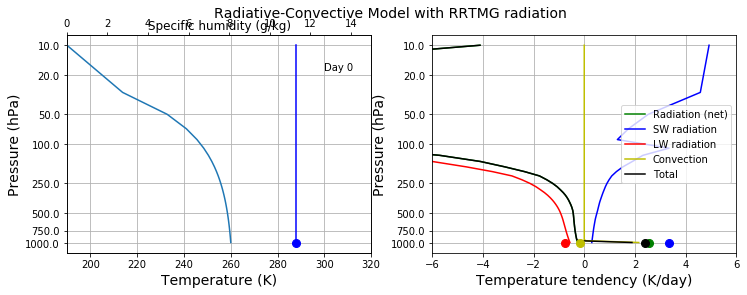

In [23]:
#  Start from isothermal state
rcm.state.Tatm[:] = rcm.state.Ts
#  Call the diagnostics once for initial plotting
rcm.compute_diagnostics()
#  Plot initial data
fig, axes, lines = initial_figure(rcm)
fig

### Now let's step forward in time and animate the solution

In [24]:
def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm))
    lines[1].set_xdata(np.array(model.Ts))
    lines[2].set_xdata(np.array(model.q)*1E3)
    tendencies_atm, tendencies_sfc = get_tendencies(model)
    for i, name in enumerate(tendencies_atm.data_vars):
        lines[3+i].set_xdata(tendencies_atm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[3+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines   

In [25]:
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))

In [26]:
HTML(ani.to_html5_video())

Plenty of interesting things to see in this animation! Discuss...

### The final figure, in case the animation isn't working

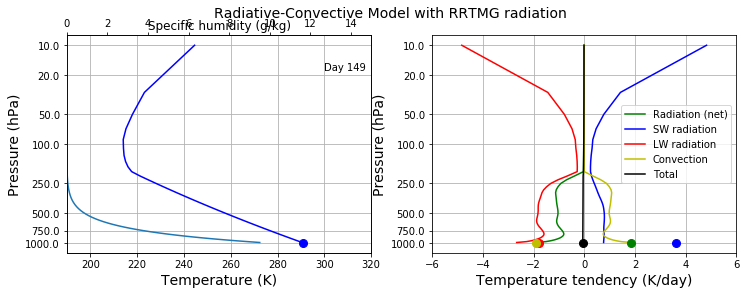

In [27]:
fig

### Reaching R-C equilibrium

The model is settling down after 150 days but is not really at equilibrium:

In [28]:
rcm.ASR - rcm.OLR

Field([-8.1149099])

So we will integrate it out further (without animation):

In [29]:
rcm.integrate_years(2)
rcm.ASR - rcm.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 2.406622235875263 years.


Field([-0.00031397])

In [30]:
#  The equilibrated surface temperature
rcm.Ts

Field([ 286.95964719])

### Plot the equilibrium

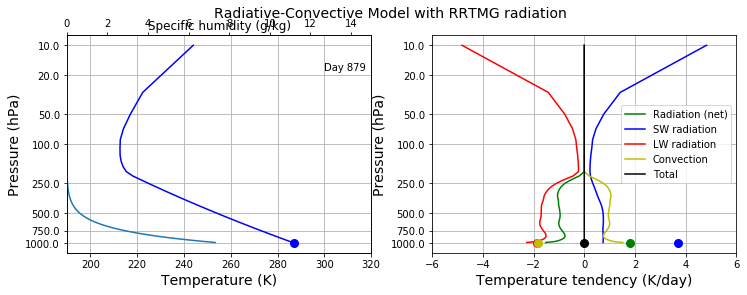

In [31]:
animate(0, rcm, lines)
fig

____________
<a id='section3'></a>

## 3. Forcing and feedback in the RCM
____________

In [32]:
#  Make a clone of our model and double CO2
rcm2 = climlab.process_like(rcm)
rcm2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2.
#  Current CO2 concentration in ppmv
print( rcm2.subprocess['Radiation'].absorber_vmr['CO2'] * 1E6)

696.0


In [33]:
#  Compute radiation forcing
rcm2.compute_diagnostics()
#  There are now changes in both longwave and shortwave from the increased CO2
DeltaOLR = rcm2.OLR - rcm.OLR
DeltaASR = rcm2.ASR - rcm.ASR
print( DeltaOLR, DeltaASR)

[-2.58247614] [ 0.056474]


In [34]:
#  The radiative forcing includes both LW and SW components
RF = DeltaASR - DeltaOLR
print( 'The radiative forcing for doubling CO2 is %0.2f W/m2.' % (RF))

The radiative forcing for doubling CO2 is 2.64 W/m2.


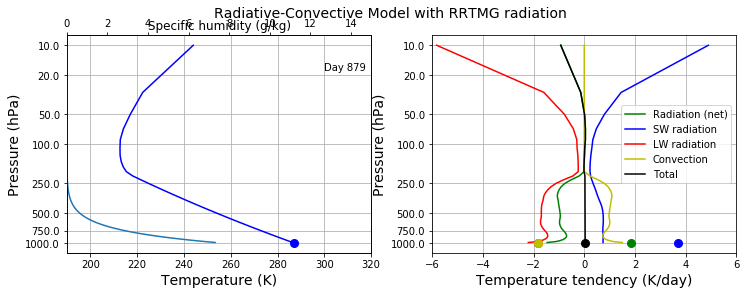

In [35]:
#  Plot initial data
fig, axes, lines = initial_figure(rcm2)
fig

You have to look carefully to see this differences from the equilibrated model above. But the LW cooling rate is *just a little smaller*.

### Adjustment after doubling CO2

In [36]:
rcm_2xCO2 = climlab.process_like(rcm2)

In [37]:
ani_2xCO2 = animation.FuncAnimation(fig, animate, frames=np.arange(1, 100), fargs=(rcm_2xCO2, lines))

In [38]:
HTML(ani_2xCO2.to_html5_video())

Ok, it's a bit like watching paint dry but the model is warming up.

What happened in the stratosphere?

#### Plot final figure, in case the animation isn't working

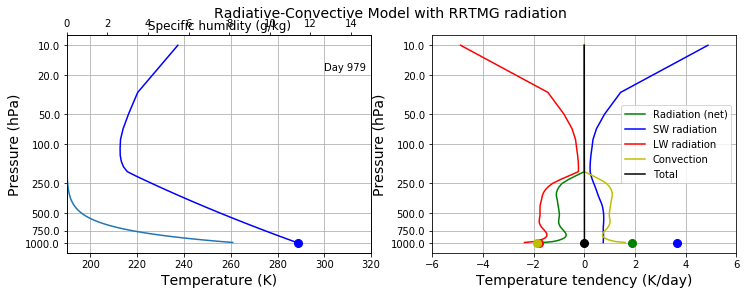

In [39]:
fig

### Integrate out to equilibrium:

In [40]:
rcm_2xCO2.ASR - rcm_2xCO2.OLR

Field([ 1.02847809])

In [41]:
rcm_2xCO2.integrate_years(2)
rcm_2xCO2.ASR - rcm_2xCO2.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 4.681824827470648 years.


Field([ -2.27759188e-07])

In [42]:
DeltaTs = float(rcm_2xCO2.Ts - rcm.Ts)
print( 'The equilibrium climate sensitivity is {:0.2f} K.'.format(DeltaTs))

The equilibrium climate sensitivity is 2.28 K.


### Plot the equilibrium

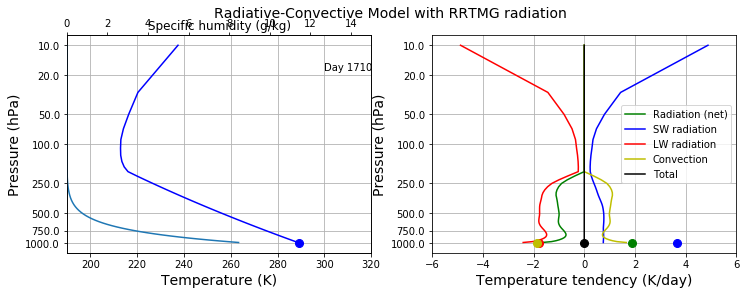

In [43]:
animate(0, rcm_2xCO2, lines)
fig

____________
<a id='section4'></a>

## 4. The role of water vapor in the warming
____________


In [44]:
rcm_noH2O = climlab.process_like(rcm2)
rcm_noH2O.remove_subprocess('WaterVapor')
print( rcm_noH2O)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (50,) 
The subprocess tree: 
top: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



The specific humidity profile is now fixed.

In [45]:
rcm_noH2O.integrate_years(2)
rcm_noH2O.ASR - rcm_noH2O.OLR

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 4.405295992631738 years.


Field([  2.33003732e-07])

Let's double-check to see if the specific humidity field changed.

In [46]:
rcm_noH2O.subprocess['Radiation'].specific_humidity == rcm2.subprocess['Radiation'].specific_humidity

Field([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [47]:
DeltaTs_noH2O = float(rcm_noH2O.Ts - rcm.Ts)
print( 'The equilibrium climate sensitivity without water vapor feedback is {:0.2f} K.'.format(DeltaTs_noH2O))

The equilibrium climate sensitivity without water vapor feedback is 1.34 K.


## Some questions to pursue:

- How would you quantify the water vapor feedback in this model?
- What determines the strength of the water vapor feedback?
- What if the distribution of relative humidity changes a little bit as part of the global warming response?

We can investigate this last question actively with our model.

____________
<a id='section5'></a>

## 5. Observed relative humidity profiles
____________

### What is the prescribed Relative Humidity profile in our model, and how does it compare to observations?

In [48]:
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log, exp

In [49]:
# This will try to read the data over the internet.
ncep_filename = 'rhum.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
path = ncep_url
#  Open handle to data
ncep_rhum = xr.open_dataset( path + ncep_filename, decode_times=False )

In [50]:
ncep_rhum

<xarray.Dataset>
Dimensions:             (lat: 73, level: 8, lon: 144, nbnds: 2, time: 12)
Coordinates:
  * level               (level) float32 1000.0 925.0 850.0 700.0 600.0 500.0 ...
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 ...
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 ...
  * time                (time) float64 -6.571e+05 -6.57e+05 -6.57e+05 ...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 ...
    rhum                (time, level, lat, lon) float64 ...
    valid_yr_count      (time, level, lat, lon) float64 ...
Attributes:
    description:                    Data from NCEP initialized reanalysis (4x...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:            

In [51]:
#  Weighting for global average
weight = cos(deg2rad(ncep_rhum.lat)) / cos(deg2rad(ncep_rhum.lat)).mean(dim='lat')

In [52]:
fig, axes = plt.subplots(2,1, figsize=(8,8))
ax = axes[0]
cax = ax.contourf(ncep_rhum.lat, ncep_rhum.level, 
                  ncep_rhum.rhum.mean(dim=('lon', 'time')),
                  cmap=plt.cm.Blues)
fig.colorbar(cax, ax=ax)
ax.set_xlabel('Latitude')
ax.set_title('Relative Humidity from NCEP Reanalysis (annual, zonal average)', fontsize=16)

ax = axes[1]
ax.plot((ncep_rhum.rhum*weight).mean(dim=('lon', 'time', 'lat')), 
        ncep_rhum.level, label='NCEP Renalysis')
# Overlay a plot of the prescribed RH profile in our model:
ax.plot(h2o.RH_profile*100., h2o.lev, label='Manabe parameterization')
ax.set_xlabel('Global average RH (%)')
ax.legend()

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (hPa)')

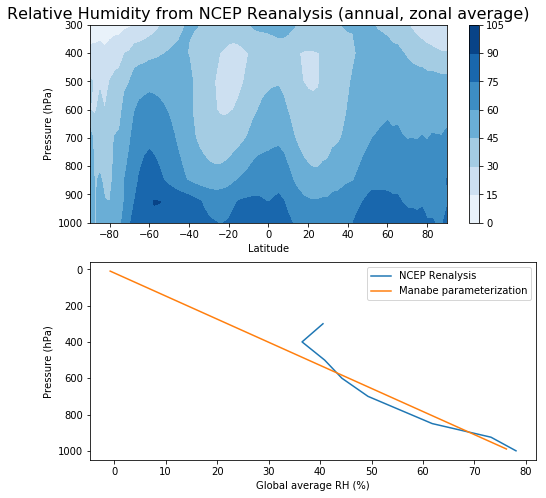

In [53]:
fig

____________
<a id='section5'></a>

## 6. Exercises on water vapor
____________

Suppose that (for reasons that are unresolved in our model) the RH profile changes. 

Specifcally let's consider a layer of (relatively) moister air in the upper troposphere, which we will implement as a Gaussian perturbation centered at 300 hPa:

In [54]:
# Gaussian bump centered at 300 hPa
def rh_pert(lev):
    return 0.2 * exp(-(lev-300.)**2/(2*50.)**2)

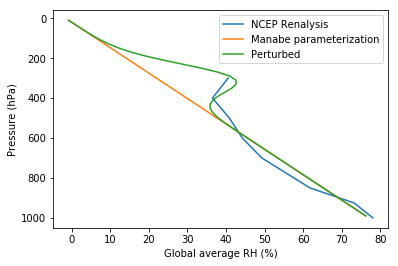

In [55]:
fig,ax = plt.subplots()
ax.plot((ncep_rhum.rhum*weight).mean(dim=('lon', 'time', 'lat')), 
        ncep_rhum.level, label='NCEP Renalysis')
# Overlay a plot of the prescribed RH profile in our model:
ax.plot(h2o.RH_profile*100., h2o.lev, label='Manabe parameterization')
ax.plot((h2o.RH_profile + rh_pert(h2o.lev))*100., h2o.lev, label='Perturbed')
ax.set_xlabel('Global average RH (%)')
ax.set_ylabel('Pressure (hPa)')
ax.legend(); ax.invert_yaxis()
fig

### Investigate how this layer of relatively moister air will affect the climate sensitivity

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________


In [56]:
%load_ext version_information
%version_information numpy, matplotlib, climlab

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.1.0
OS Darwin 17.3.0 x86_64 i386 64bit
numpy 1.13.1
matplotlib 2.0.2
climlab 0.6.1
Mon Jan 08 18:13:14 2018 CST

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________